In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
from config import config

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("data/final.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
tst_size=20
trn, tst = data[:-tst_size], data[-tst_size:]

In [3]:
patchparams = config['PatchTST']['model_params']
patch_length = patchparams['patch_length'] #고정
n_patch = patchparams['n_patch']
n_token = patchparams['n_token']  #조정
patch_batch_size = patchparams['patch_batch_size']
patch_model_dim = patchparams['patch_model_dim'] #고정
patch_num_heads = patchparams['patch_num_heads']  #고정
patch_num_layers = patchparams['patch_num_layers']  #고정
patch_output_dim = tst_size

In [4]:
patchdata = PatchLoadData(data, n_patch, patch_length, tst_size, patch_batch_size)
patch_trn_dl , patch_tst_dl, patch_trn_ds = patchdata.scaling()

7

In [5]:
patchmodel = PatchTST(n_patch, patch_length, patch_model_dim, patch_num_heads, patch_num_layers, patch_output_dim)
patchmodel.load_state_dict(torch.load("./modelpth/PatchTST/PatchTST_AdamW_epochs_2000_n_patch_4_patch_length_16_lr0.001.pth"))

<All keys matched successfully>

## Main

In [8]:
trn.shape, tst.shape

((1696, 1), (20, 1))

In [9]:
x.shape, y.shape

(torch.Size([1, 4, 16]), (20,))

MAPE:  7.004644043832406
MAE:  0.0807536015510559
R2_Score:  0.11388705527715337


<Axes: xlabel='YearMonth'>

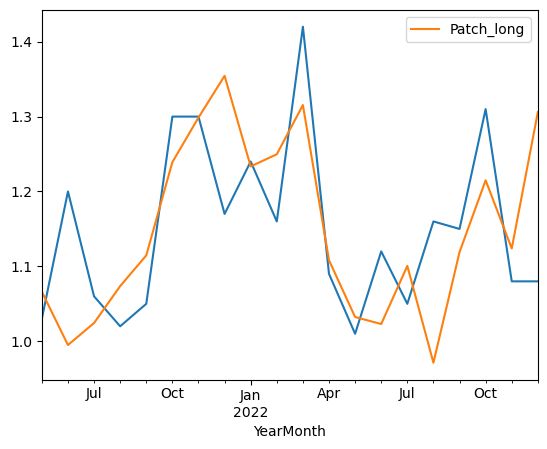

In [11]:
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
window_size = int(n_patch * patch_length/2)
scaler = patchdata.get_scaler()
eval = trn[-window_size:]
eval = eval.to_numpy()
eval = scaler.transform(eval.reshape(-1, 1))
last8 = eval[-1]
eval = eval.squeeze()
eval_concat = np.concatenate([eval, last8*np.ones(8,dtype=np.float32)])
x = np.array([eval_concat[i*8:(i+2)*8] for i in range(4)])
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y=patchmodel(x_tensor)
y = y.detach().cpu().numpy()
scaler = patchdata.get_scaler()
preds = scaler.inverse_transform(y).squeeze()

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"Patch_long": preds}, index=tst.index)
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [ ]:
preds